In [12]:
import numpy as np
import pandas as pd
from __future__ import division
from random import shuffle
import xmltodict
import json
import collections
from collections import Counter

import nltk
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.feature_extraction.text import *
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix

from gensim.models import LdaModel
from gensim.corpora import Dictionary

# view all columns of pandas df
pd.set_option('display.max_columns', None)

# nltk.download('wordnet')      # download wordnet if it's not already downloaded

with open ("dreambank-public.xml") as f:
    doc = xmltodict.parse(f.read())

def convert(data):
    if isinstance(data, basestring):
        return str(data)
    elif isinstance(data, collections.Mapping):
        return dict(map(convert, data.iteritems()))
    elif isinstance(data, collections.Iterable):
        return type(data)(map(convert, data))
    else:
        return data

def left(s, amount):
    return s[:amount]

def right(s, amount):
    return s[-amount:]

def mid(s, offset, amount):
    return s[offset:offset+amount]

# Exploratory Analysis

First we want to print the data to see which fields we are given and how the data looks.

In [13]:
for dreamer in doc['dreambank']['collection']:
    print dreamer['name'] + ' (' + str(len(dreamer['dream'][:])) + ' dreams)' 
    print '  ID: ' + dreamer['id']
    print '  type: ' + dreamer['type']
    print '  sex: ' + dreamer['sex']
    print '  age: ' + dreamer['age']
    
    try:
        print '  time: ' + dreamer['time']
    except:
        pass
    
    print '  sample dream: ' 
    
    odict = dreamer['dream'][0]
    for key, value in odict.items():
        if convert(key) == 'report':
            print '    report: ' + left(convert(value), 200) + '...'
        else:
            print '    ' + convert(key) + ': ' + str(convert(value))
        
    print '\n'

Alta: a detailed dreamer (422 dreams)
  ID: alta
  type: series
  sex: F
  age: A
  time: 1985-1997
  sample dream: 
    number: 1
    date: 1957
    report: The one at the Meads's house, where it's bigger inside than out; there's a European village just inside, with a cobblestone street and a Pied-Piper sort of man with curly hair, he can do things like j...


Angie: age 18 & 20 (48 dreams)
  ID: angie
  type: series
  sex: F
  age: Y
  time: 1996
  sample dream: 
    number: 1-01
    date: 1996-04-03
    report: My memory of this dream is vague. I think the setting is on a college campus. I'm in a cafe and two elderly ladies walk in and start talking to me about a university that a guy I am dating got into fo...


Arlie: a middle-aged woman (212 dreams)
  ID: arlie
  type: series
  sex: F
  age: A
  time: 1992-1998
  sample dream: 
    number: 1
    date: 10/14/92
    report: I am in an office in the town next to the town I grew up in. Everyone is taking a rest. I have to go to the b

In [14]:
print '---Dream collections from individuals---' + '\n'
MultIDs = ['b', 'madeline1-hs', 'madeline2-dorms', 'madeline3-offcampus', 'phil1', 'phil2', 'vietnam_vet']
NumberOfSeries = 1

for dreamer in doc['dreambank']['collection']:
    if dreamer['type'] == 'series':
        print '{' + dreamer['id']  + '} ' + dreamer['name'] + ' (' + str(len(dreamer['dream'][:])) + ' dreams)' + ' [' + dreamer['sex'] + ']'    
        dreamer['w266ID'] = NumberOfSeries
        
        # Assign a dreamer ID that groups the same dreamers together 
        # and skips the dream collections of multiple dreamers
        print 'w266 ID: ' + str(dreamer['w266ID'])
        if dreamer['id'] not in MultIDs:
            print '\n'
            NumberOfSeries += 1
    else:
        dreamer['w266ID'] = 0
        
print "Total Number of individuals to test vs. 'others': " + str(NumberOfSeries - 1)

---Dream collections from individuals---

{alta} Alta: a detailed dreamer (422 dreams) [F]
w266 ID: 1


{angie} Angie: age 18 & 20 (48 dreams) [F]
w266 ID: 2


{arlie} Arlie: a middle-aged woman (212 dreams) [F]
w266 ID: 3


{b} Barb Sanders (3116 dreams) [F]
w266 ID: 4
{b2} Barb Sanders #2 (1138 dreams) [F]
w266 ID: 4


{bosnak} Robert Bosnak: A dream analyst (53 dreams) [M]
w266 ID: 5


{chris} Chris: a transvestite (100 dreams) [M]
w266 ID: 6


{chuck} Chuck: a physical scientist (75 dreams) [M]
w266 ID: 7


{dahlia} Dahlia: concerns with appearance (24 dreams) [F]
w266 ID: 8


{david} David: teenage dreams (166 dreams) [M]
w266 ID: 9


{dorothea} Dorothea: 53 years of dreams (900 dreams) [F]
w266 ID: 10


{ed} Ed: dreams of his late wife (143 dreams) [M]
w266 ID: 11


{edna} Edna: a blind woman (19 dreams) [F]
w266 ID: 12


{elizabeth} Elizabeth: a woman in her 40s (1707 dreams) [F]
w266 ID: 13


{emma} Emma: 48 years of dreams (1521 dreams) [F]
w266 ID: 14


{emmas_husband} Emma's

In [15]:
DreamNum = 0

for dreamer in doc['dreambank']['collection']:
    for odict in dreamer['dream']:
        for key, value in odict.items():            
            if convert(key) == 'report':
                DreamNum += 1

print "Total Dreams: " + str(DreamNum)

Total Dreams: 26000


# EDA - Reduce To Noun-Only And Lemmatize

For our topic modeling, we will want to lemmatize the corpus and reduce to nouns-only. However, before we get to topic modeling, it will be helpful to test out the lemmatization and noun-only reduction techniques.

In [16]:
# reduce to noun-only and lemmatize

lmtzr = WordNetLemmatizer()

for dreamer in doc['dreambank']['collection']:
    print dreamer['name'] + ' (' + str(len(dreamer['dream'][:])) + ' dreams)' + ' [' + dreamer['sex'] + ']'
    
    print '  noun-only sample dream: ' 
    
    odict = dreamer['dream'][0]
    
    # (1) tokenize dream text
    # (2) tag with PoS
    # (3) reduce to noun-only
    # (4) lemmatize nouns
    # (5) get frequency counts of the lemmatized nouns
    for key, value in odict.items():
        if convert(key) == 'report':
            text = nltk.tokenize.word_tokenize(value)
            print "tokenized: " + str(text)
            pos = nltk.pos_tag(text)            
            noun_only = [w[0] for w in pos if w[1].startswith('N')]
            print "noun only: " + str(noun_only)
            lmtz_noun_only = [lmtzr.lemmatize(word) for word in noun_only]
            print "lemmatized: " + str(lmtz_noun_only)
            counts = Counter(lmtz_noun_only)
            print counts
        
    print '\n'

Alta: a detailed dreamer (422 dreams) [F]
  noun-only sample dream: 
tokenized: [u'The', u'one', u'at', u'the', u'Meads', u"'s", u'house', u',', u'where', u'it', u"'s", u'bigger', u'inside', u'than', u'out', u';', u'there', u"'s", u'a', u'European', u'village', u'just', u'inside', u',', u'with', u'a', u'cobblestone', u'street', u'and', u'a', u'Pied-Piper', u'sort', u'of', u'man', u'with', u'curly', u'hair', u',', u'he', u'can', u'do', u'things', u'like', u'juggle', u'-', u'I', u'go', u'up', u'the', u'back', u'stairs', u'[', u'there', u'are', u"n't", u'any', u'in', u'the', u'real', u'house', u']', u'and', u'then', u'down', u'the', u'other', u'side', u'[', u'since', u'there', u"'s", u'a', u'second', u'set', u',', u'immediately', u']', u'then', u'down', u'a', u'short', u'empty', u'hallway', u'that', u'turns', u'a', u'corner', u',', u'where', u'I', u'find', u'a', u'tiny', u'room', u'...', u'a', u'young', u'woman', u'with', u'shoulder-length', u'blonde', u'hair', u'in', u'a', u'pageboy', u'

noun only: [u'moon', u'thing', u'sun', u'friend', u'Anna', u'L.', u'Rita', u'L.', u'mom', u'Anna', u'mom', u'someone', u'mom', u'Rita', u'moon', u'people', u'moon', u'man', u'Al', u'L.', u'Anna', u'father', u'moon', u'earth', u'people', u'moon', u'person', u'Al', u'Al', u'person', u'people', u'moon', u'person', u'Al', u'person', u'Rita', u'moon', u'person', u'Rita', u'people', u'moon', u'proof', u'Rita', u'earrings', u'end', u'UL', u'>', u'<', u'LI', u'>', u'Setting', u'Part', u'room', u'part', u'moon.', u'<', u'/LI', u'>', u'<', u'LI', u'>', u'Characters', u'friend', u'Anna', u'friend', u'people', u'Anna', u'parents', u'Al', u'Rita', u'Anna', u'hair', u'eyes', u'hair', u'medium', u'Rita', u'hair', u'shirt', u'pants', u'Al', u'shorts', u'flannel', u'shirt.', u'<', u'/LI', u'>', u'<', u'LI', u'>', u'Feelings', u'Thoughts', u'Worried', u'dream', u'<', u'/LI', u'>', u'<', u'/UL', u'>']
lemmatized: [u'moon', u'thing', u'sun', u'friend', u'Anna', u'L.', u'Rita', u'L.', u'mom', u'Anna', u'mo

noun only: [u'profile', u'illness', u'point', u'dream', u'view', u'Maria', u'cheeks', u'Mary', u'TV', u'scene', u'someone', u'person', u'voice', u'background', u'Ed']
lemmatized: [u'profile', u'illness', u'point', u'dream', u'view', u'Maria', u'cheek', u'Mary', u'TV', u'scene', u'someone', u'person', u'voice', u'background', u'Ed']
Counter({u'profile': 1, u'illness': 1, u'point': 1, u'TV': 1, u'Ed': 1, u'cheek': 1, u'scene': 1, u'voice': 1, u'person': 1, u'someone': 1, u'background': 1, u'view': 1, u'dream': 1, u'Mary': 1, u'Maria': 1})


Edna: a blind woman (19 dreams) [F]
  noun-only sample dream: 
tokenized: [u'I', u'was', u'out', u'eating', u'and', u'it', u'was', u'a', u'very', u'nice', u'place', u'.', u'There', u'were', u'five', u'of', u'us', u',', u'Mother', u'and', u'Father', u'and', u'two', u'other', u'people', u',', u'a', u'man', u'and', u'a', u'woman', u'.', u'Father', u'was', u'on', u'my', u'right', u',', u'around', u'the', u'corner', u'from', u'me', u',', u'and', u'to', u'm

noun only: [u'windbreaker', u'chair', u'display', u'style', u'quality', u'lot', u'account', u'color', u'housemates']
lemmatized: [u'windbreaker', u'chair', u'display', u'style', u'quality', u'lot', u'account', u'color', u'housemate']
Counter({u'style': 1, u'color': 1, u'account': 1, u'housemate': 1, u'lot': 1, u'windbreaker': 1, u'chair': 1, u'quality': 1, u'display': 1})


Mark: a young boy (23 dreams) [M]
  noun-only sample dream: 
tokenized: [u'I', u'was', u'at', u'the', u'park', u'.', u'I', u'had', u'these', u'little', u'cars', u'in', u'my', u'hand', u',', u'I', u'was', u'riding', u'a', u'bicycle', u'.', u'The', u'I', u'crashed', u'into', u'a', u'car', u'.', u'The', u'cars', u'in', u'my', u'hand', u'got', u'bigger', u'and', u'I', u'got', u'in', u'them', u'.', u'This', u'little', u'girl', u'had', u'some', u'in', u'her', u'hand', u'and', u'wanted', u'to', u'drive', u'in', u'them', u'.', u'I', u'went', u'into', u'a', u'fort', u'and', u'this', u'guy', u'did', u"n't", u'want', u'us', u'

noun only: [u'Uncle', u'Albert', u'vacation', u'Uncle', u'Albert', u'someone', u'a.m.', u'difference', u'Someone', u'Uncle', u'Joe', u'way', u'home', u'school', u'summer', u'school', u'Pat', u'Byers', u'goodbye', u'rooms', u'floor', u'door', u'look', u'Everyone', u'lot', u'fun', u'trouble', u'class', u'school', u'someone', u'goodbye', u'back', u'head', u'room', u'upstairs', u'how..', u'time', u'dark', u'dark', u'Uncle', u'Joe', u'building', u'etc.']
lemmatized: [u'Uncle', u'Albert', u'vacation', u'Uncle', u'Albert', u'someone', u'a.m.', u'difference', u'Someone', u'Uncle', u'Joe', u'way', u'home', u'school', u'summer', u'school', u'Pat', u'Byers', u'goodbye', u'room', u'floor', u'door', u'look', u'Everyone', u'lot', u'fun', u'trouble', u'class', u'school', u'someone', u'goodbye', u'back', u'head', u'room', u'upstairs', u'how..', u'time', u'dark', u'dark', u'Uncle', u'Joe', u'building', u'etc.']
Counter({u'Uncle': 4, u'school': 3, u'Albert': 2, u'Joe': 2, u'someone': 2, u'dark': 2, u'ro

tokenized: [u'My', u'mom', u'and', u'I', u'were', u'in', u'the', u'grocery', u'store', u'.', u'I', u'went', u'over', u'to', u'the', u'free', u'cookie', u'area', u'.', u'And', u'this', u'guy', u'gave', u'me', u'a', u'cookie', u'.', u'I', u'had', u'seen', u'the', u'cookies', u',', u'and', u'they', u'were', u'pretend', u'grasshoppers', u'.', u'I', u'saw', u'a', u'little', u'spider', u'go', u'by', u'(', u'on', u'the', u'cookie', u')', u'.', u'I', u'said', u',', u'``', u'Oh', u',', u'I', u'do', u"n't", u'like', u'this', u'cookie', u'.', u"''", u'I', u'thought', u'it', u'was', u'gross', u'.', u'But', u'then', u'all', u'these', u'other', u'kids', u'came', u'.', u'I', u'took', u'the', u'cookie', u'.', u'I', u'do', u"n't", u'know', u'what', u'happened', u'after', u'that', u'about', u'the', u'cookie', u'.', u'The', u'guy', u'behind', u'the', u'counter', u'gave', u'us', u'dolls', u'.', u'We', u'did', u'something', u'with', u'the', u'dolls', u',', u'and', u'then', u'we', u'put', u'them', u'back', 

# Create Dataframe

In [17]:
ID = 0
W266ID = 0
DreamBankID = ''
DreamNumber = ''
Name = ''
Sex = ''
Dream = ''
HasDream = 0

df = pd.DataFrame(columns=["ID", "W266ID", "DreamBankID", "DreamNumber", "Name", "Sex", "Dream"])

for dreamer in doc['dreambank']['collection']:
    Name = dreamer['name'] 
    DreamBankID = dreamer['id']
    W266ID = int(dreamer['w266ID'])
    Sex = dreamer['sex']
    
    for odict in dreamer['dream']:
        HasDream = 0
        for key, value in odict.items():
            if convert(key) == 'report':
                Dream = convert(value)
                HasDream = 1
            if convert(key) == 'number':
                DreamNumber = convert(value)
        
        if HasDream == 1:
            ID += 1
            df = df.append({
                "ID": ID,
                "W266ID": W266ID,
                "DreamBankID": DreamBankID,
                "DreamNumber": DreamNumber,
                "Name": Name,
                "Sex": Sex,
                "Dream": Dream
                }, ignore_index=True)        
#     print '\n'

# print df
print "Total Dreams: " + str(ID)
print "\n"

df.head()

Total Dreams: 26000




,ID,W266ID,DreamBankID,DreamNumber,Name,Sex,Dream
0,1,1,alta,1,Alta: a detailed dreamer,F,"The one at the Meads's house, where it's bigge..."
1,2,1,alta,2,Alta: a detailed dreamer,F,I'm at a family reunion in a large fine house ...
2,3,1,alta,3,Alta: a detailed dreamer,F,I watch a plane fly past and shortly realize i...
3,4,1,alta,4,Alta: a detailed dreamer,F,Me pulling the green leaves and berries off so...
4,5,1,alta,5,Alta: a detailed dreamer,F,I'm in a room that reminds me of (but definite...


In [19]:

#DreamerID = 1
#df2 = df.loc[df['W266ID'] == DreamerID
             
#df2.head()

#dreamsgraph = " ".join(dreams)        
#dreamsgraph = list(nltk.tokenize.word_tokenize(dreamsgraph))
#dreamsgraph = [word for word in dreamsgraph if word not in stopwords.words('english')]
#dreamsgraph = [word for word in dreamsgraph if word not in ['x94', 'x92t', 'ti', 'x92d', 'x92s', 'x85']]

#counts = Counter(dreamsgraph)
#for k in list(counts):
#    if counts[k] < 40:
#        del counts[k]

#print counts

#labels, values = zip(*counts.items())        

## sort in descending order
#indSort = np.argsort(values)[::-1]

#labels = np.array(labels)[indSort]
#values = np.array(values)[indSort]
#indexes = np.arange(len(labels))

#plt.bar(indexes, values, align='center', alpha=0.5, color='blue')
#plt.xticks(indexes, labels, rotation=45) #+ bar_width

## Get current size
#fig_size = plt.rcParams["figure.figsize"]
## print "Current size:", fig_size

## Set figure width to 12 and height to 9
#fig_size[0] = 16
#fig_size[1] = 12
#plt.rcParams["figure.figsize"] = fig_size

#plt.show()


In [20]:
print 'Males: ' + str(len(df[df['Sex']=='M']))
print 'Females: ' + str(len(df[df['Sex']=='F']))
print 'Total: ' + str(len(df[df['Sex']=='M']) + len(df[df['Sex']=='F']))

Males: 7813
Females: 18187
Total: 26000


# Modeling

We want to create a different model for each dreamer (i.e. a classifier identifying one vs all-others for each dreamer). This will allow us to identify the most predictive words in identifying each dreamer.

In [21]:
# randomly shuffle dataframe
# set seed for consistency while running
np.random.seed(0)
df = df.sample(frac=1).reset_index(drop=True)
    
# add 41 flag columns denoting dreamers (one col per dreamer) 
dreamer_flag = pd.get_dummies(df['W266ID'], prefix='Dreamer')
df = pd.concat([df, dreamer_flag], axis=1)

# create vocab from all dreams
dreams_flat = df['Dream'].values.flatten().tolist()
dreams_list = " ".join(dreams_flat)
vocab = list(set(nltk.tokenize.word_tokenize(dreams_list)))

# Why does this blow up the shape later?
#pos = nltk.pos_tag(vocab)            
#noun_only = [w[0] for w in pos if w[1].startswith('N')]
#vocab = [lmtzr.lemmatize(word) for word in noun_only]
#vocab = list(set(vocab)) # get rid of duplicates

print vocab[1:500]

def split_data(df, W266ID, train=0.6):        
    # column for "our" dreamer
    dreamer_label = 'Dreamer_' + str(W266ID)

    # make 60/40 split of train/test
    # test will be evenly split between dev and test in the next step
    num_train = int(len(df) * train)
    num_test = int(len(df) * (1-train)) 

    train_data, train_labels = df['Dream'][:num_train], df[dreamer_label][:num_train]
    dev_data, dev_labels = df['Dream'][-num_test : -num_test//2], df[dreamer_label][-num_test : -num_test//2] 
    test_data, test_labels = df['Dream'][-num_test//2:], df[dreamer_label][-num_test//2:]

    return train_data, train_labels, dev_data, dev_labels, test_data, test_labels

['Ptomeny', 'grandniece', '1,800', 'wrought-iron', 'Poetry', "'glue", 'woods', 'clotted', 'spiders', 'hanging', 'woody', 'comically', 'localized', 'Prone', 'sevens', 'disobeying', 'caner', 'canes', 'DISAPPOINTED', 'unpaused', 'scold', 'jell-o', 'Vulcan', 'Western', 'unhistoric', 'Retreat', 'bocks', 'PETRIFIED', 'higher-ups', 'button-down', 'Blade', 'lockmold*', 'pigment', 'capoeira', "'Love", 'screaming', 'revelers', 'wooded', 'spacy', 'broiler', 'wooden', 'something-anything', 'Saco', 'back-handsprings', 'circuitry', 'crotch', 'stereotypical', 'seven-', 'guardsmen', 'cash/copy', 'them-but', 'undead', 'Print-Shop', 'snuggles', 'scrapes', 'scraper', 'Balling', 'feasibility', 'miniatures', '273', 'Diapering', 'Pierce-Gage', '276', 'Jiminy', 'spindly', 'scraped', 'snuggled', 'inanimate', 'errors', 'dialogs', 'semicircular', 'Initially', "'eigh", 'cooking', "'score", '6^X2', 'cores', 'Hamilton', 'Puddleduck', 'designing', 'College', 'spidery', 'hallucinating', 'succumb', 'kid.', "'pleasure

In [22]:
# split data for dreamer1 - Alta
train_data, train_labels, dev_data, dev_labels, test_data, test_labels = split_data(df, W266ID=1)
    
# Create a Bag-of-Words Vectorizer
vec = CountVectorizer(vocabulary=vocab)
vec_bow_train_data = vec.fit_transform(train_data)
vec_bow_dev_data = vec.transform(dev_data)  

# Create a Tfidf Vectorizer
vec_tfidf = TfidfVectorizer(stop_words='english')
vec_tfidf_train_data = vec_tfidf.fit_transform(train_data)
vec_tfidf_dev_data   = vec_tfidf.transform(dev_data)

best_lr_score = 0

## Logistic reg
for c in (0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 500):
    bow_log = LogisticRegression(C = c)
    bow_log.fit(vec_bow_train_data, train_labels)
    
    tfidf_logit_model = LogisticRegression(C=c)
    tfidf_logit_model.fit(vec_tfidf_train_data, train_labels)
    
    f1_bow_lr_score = metrics.f1_score(dev_labels, bow_log.predict(vec_bow_dev_data), average='macro')    
    f1_tfidf_lr_score = metrics.f1_score(dev_labels, tfidf_logit_model.predict(vec_tfidf_dev_data), average='macro') 

    print 'Logistic Reg:\t C=%3.4f\t BOW: F1-score=%3.3f\t TFIDF: F1-score=%3.3f' % (c, f1_bow_lr_score, f1_tfidf_lr_score)

    if f1_bow_lr_score > best_lr_score:
        best_lr_score = f1_bow_lr_score
        best_C = c 
        vectorizer = 'BOW'
        
    if f1_tfidf_lr_score > best_lr_score:
        best_lr_score = f1_tfidf_lr_score
        best_C = c
        vectorizer = 'TFIDF'

print ''
print 'Best model:\t C=%3.4f\t vectorizer = %s\t F1-score=%3.3f' % (best_C, vectorizer, best_lr_score)

C:\Users\Jay\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Logistic Reg:	 C=0.0001	 BOW: F1-score=0.496	 TFIDF: F1-score=0.496
Logistic Reg:	 C=0.0010	 BOW: F1-score=0.778	 TFIDF: F1-score=0.496
Logistic Reg:	 C=0.0100	 BOW: F1-score=0.878	 TFIDF: F1-score=0.496
Logistic Reg:	 C=0.1000	 BOW: F1-score=0.916	 TFIDF: F1-score=0.496
Logistic Reg:	 C=1.0000	 BOW: F1-score=0.933	 TFIDF: F1-score=0.712
Logistic Reg:	 C=10.0000	 BOW: F1-score=0.930	 TFIDF: F1-score=0.872
Logistic Reg:	 C=100.0000	 BOW: F1-score=0.934	 TFIDF: F1-score=0.912
Logistic Reg:	 C=500.0000	 BOW: F1-score=0.931	 TFIDF: F1-score=0.909

Best model:	 C=100.0000	 vectorizer = BOW	 F1-score=0.934


In [23]:
# split data for dreamer2 - Angie
train_data, train_labels, dev_data, dev_labels, test_data, test_labels = split_data(df, W266ID=2)
    
# Create a Bag-of-Words Vectorizer
vec = CountVectorizer(vocabulary=vocab)
vec_bow_train_data = vec.fit_transform(train_data)
vec_bow_dev_data = vec.transform(dev_data)  

# Create a Tfidf Vectorizer
vec_tfidf = TfidfVectorizer(stop_words='english')
vec_tfidf_train_data = vec_tfidf.fit_transform(train_data)
vec_tfidf_dev_data   = vec_tfidf.transform(dev_data)

best_lr_score = 0

## Logistic reg
for c in (0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 500):
    bow_log = LogisticRegression(C = c)
    bow_log.fit(vec_bow_train_data, train_labels)
    
    tfidf_logit_model = LogisticRegression(C=c)
    tfidf_logit_model.fit(vec_tfidf_train_data, train_labels)
    
    f1_bow_lr_score = metrics.f1_score(dev_labels, bow_log.predict(vec_bow_dev_data), average='macro')    
    f1_tfidf_lr_score = metrics.f1_score(dev_labels, tfidf_logit_model.predict(vec_tfidf_dev_data), average='macro') 

    print 'Logistic Reg:\t C=%3.4f\t BOW: F1-score=%3.3f\t TFIDF: F1-score=%3.3f' % (c, f1_bow_lr_score, f1_tfidf_lr_score)

    if f1_bow_lr_score > best_lr_score:
        best_lr_score = f1_bow_lr_score
        best_C = c 
        vectorizer = 'BOW'
        
    if f1_tfidf_lr_score > best_lr_score:
        best_lr_score = f1_tfidf_lr_score
        best_C = c
        vectorizer = 'TFIDF'

print ''
print 'Best model:\t C=%3.4f\t vectorizer = %s\t F1-score=%3.3f' % (best_C, vectorizer, best_lr_score)

Logistic Reg:	 C=0.0001	 BOW: F1-score=0.500	 TFIDF: F1-score=0.500
Logistic Reg:	 C=0.0010	 BOW: F1-score=0.500	 TFIDF: F1-score=0.500
Logistic Reg:	 C=0.0100	 BOW: F1-score=0.500	 TFIDF: F1-score=0.500
Logistic Reg:	 C=0.1000	 BOW: F1-score=0.500	 TFIDF: F1-score=0.500
Logistic Reg:	 C=1.0000	 BOW: F1-score=0.500	 TFIDF: F1-score=0.500
Logistic Reg:	 C=10.0000	 BOW: F1-score=0.590	 TFIDF: F1-score=0.500
Logistic Reg:	 C=100.0000	 BOW: F1-score=0.590	 TFIDF: F1-score=0.500
Logistic Reg:	 C=500.0000	 BOW: F1-score=0.590	 TFIDF: F1-score=0.500

Best model:	 C=10.0000	 vectorizer = BOW	 F1-score=0.590


In [24]:
# split data for dreamer3 - Arlie
train_data, train_labels, dev_data, dev_labels, test_data, test_labels = split_data(df, W266ID=3)
    
# Create a Bag-of-Words Vectorizer
vec = CountVectorizer(vocabulary=vocab)
vec_bow_train_data = vec.fit_transform(train_data)
vec_bow_dev_data = vec.transform(dev_data)  

# Create a Tfidf Vectorizer
vec_tfidf = TfidfVectorizer(stop_words='english')
vec_tfidf_train_data = vec_tfidf.fit_transform(train_data)
vec_tfidf_dev_data   = vec_tfidf.transform(dev_data)

best_lr_score = 0

## Logistic reg
for c in (0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 500):
    bow_log = LogisticRegression(C = c)
    bow_log.fit(vec_bow_train_data, train_labels)
    
    tfidf_logit_model = LogisticRegression(C=c)
    tfidf_logit_model.fit(vec_tfidf_train_data, train_labels)
    
    f1_bow_lr_score = metrics.f1_score(dev_labels, bow_log.predict(vec_bow_dev_data), average='macro')    
    f1_tfidf_lr_score = metrics.f1_score(dev_labels, tfidf_logit_model.predict(vec_tfidf_dev_data), average='macro') 

    print 'Logistic Reg:\t C=%3.4f\t BOW: F1-score=%3.3f\t TFIDF: F1-score=%3.3f' % (c, f1_bow_lr_score, f1_tfidf_lr_score)

    if f1_bow_lr_score > best_lr_score:
        best_lr_score = f1_bow_lr_score
        best_C = c 
        vectorizer = 'BOW'
        
    if f1_tfidf_lr_score > best_lr_score:
        best_lr_score = f1_tfidf_lr_score
        best_C = c
        vectorizer = 'TFIDF'

print ''
print 'Best model:\t C=%3.4f\t vectorizer = %s\t F1-score=%3.3f' % (best_C, vectorizer, best_lr_score)

Logistic Reg:	 C=0.0001	 BOW: F1-score=0.498	 TFIDF: F1-score=0.498
Logistic Reg:	 C=0.0010	 BOW: F1-score=0.498	 TFIDF: F1-score=0.498
Logistic Reg:	 C=0.0100	 BOW: F1-score=0.527	 TFIDF: F1-score=0.498
Logistic Reg:	 C=0.1000	 BOW: F1-score=0.672	 TFIDF: F1-score=0.498
Logistic Reg:	 C=1.0000	 BOW: F1-score=0.765	 TFIDF: F1-score=0.498
Logistic Reg:	 C=10.0000	 BOW: F1-score=0.773	 TFIDF: F1-score=0.580
Logistic Reg:	 C=100.0000	 BOW: F1-score=0.780	 TFIDF: F1-score=0.689
Logistic Reg:	 C=500.0000	 BOW: F1-score=0.780	 TFIDF: F1-score=0.708

Best model:	 C=100.0000	 vectorizer = BOW	 F1-score=0.780


In [25]:
# # split data for dreamer1 - Alta
# train_data, train_labels, dev_data, dev_labels, test_data, test_labels = split_data(df, W266ID=1)
    
# # Create a Bag-of-Words Vectorizer
# vec = CountVectorizer(vocabulary=vocab)
# vec_train_data = vec.fit_transform(train_data)
# vec_dev_data = vec.transform(dev_data)  

# log = LogisticRegression(C = 100)
# log.fit(vec_train_data, train_labels)

# test_df = pd.DataFrame('Labels': [dev_labels], 'Prediction': log.predict(vec_dev_data), 'Correct_Pred': dev_labels==log.predict(vec_dev_data))
# data = {'Labels': dev_labels, 'Prediction': log.predict(vec_dev_data), 'Correct_Pred': dev_labels==log.predict(vec_dev_data)}
# test_df = pd.DataFrame(data)
# test_df.head(30)

# print confusion_matrix(dev_labels, log.predict(vec_dev_data))

## Run a model for each dreamer

We need to run a separate model for each dreamer. The models will predict if a dream comes from that dreamer or from "all-others". Since bag-of-words was working best in the above models, we will continue to use that for our baseline.

In [26]:
# Run Logisitic Regression for each dreamer

models = {}

for i in range(0,41):
    # split data
    train_data, train_labels, dev_data, dev_labels, test_data, test_labels = split_data(df, W266ID=i)

    # Create a Bag-of-Words Vectorizer
    vec = CountVectorizer(vocabulary=vocab)
    vec_train_data = vec.fit_transform(train_data)
    vec_dev_data = vec.transform(dev_data)  

    ## Logistic reg
    log = LogisticRegression(C = 100)
    log.fit(vec_bow_train_data, train_labels)

    # score model
    f1_score = metrics.f1_score(dev_labels, log.predict(vec_dev_data), average='macro')
    
    # find the most-predictive features
    ### we're not using the weights currently, but might be useful/interesting later ###    
    best_feature_positions = log.coef_.argsort()[0][-5::]
    best_feature_weights = log.coef_[0][best_feature_positions.astype(int)]

    # get word labels for our features
    words = []
    for ft in best_feature_positions.astype(int):
        words.append(vec.get_feature_names()[ft])
    
    models[i] = (log, f1_score, words)

## Most Predictive Words

Now that we have a separate model for each dreamer, we can pull out the most predictive words from each model. This shows, for a given dreamer, which words are most predictive of their dreams as opposed to someone else's dream.

In [27]:
for key, (model, score, predictive_words) in models.iteritems():
    print 'W266ID='+str(key), '\tMost Predictive', predictive_words

W266ID=0 	Most Predictive ['instructor', 'border', 'characters', 'setting', 'dreamed']
W266ID=1 	Most Predictive ['rather', 'somewhere', 'somebody', 'here', 're']
W266ID=2 	Most Predictive ['children', 'quarter', 'campus', 'meet', 'pancakes']
W266ID=3 	Most Predictive ['poison', 'hometown', 'picture', 'husband', 'model']
W266ID=4 	Most Predictive ['helpful', 'nightmares', 'nightmare', 'neat', 'scary']
W266ID=5 	Most Predictive ['stands', 'leading', 'red', 'ghost', 'world']
W266ID=6 	Most Predictive ['street', 'bunk', 'note', 'stranger', 'reach']
W266ID=7 	Most Predictive ['surprise', 'standing', 'real', 'burglar', 'few']
W266ID=8 	Most Predictive ['looked', 'toilet', 'red', 'bathroom', 'period']
W266ID=9 	Most Predictive ['definitely', 'stack', 'abstract', 'buick', 'insured']
W266ID=10 	Most Predictive ['mixed', 'preaching', 'teaching', 'miss', 'hats']
W266ID=11 	Most Predictive ['dream', 'mood', 'both', 'clearly', 'looks']
W266ID=12 	Most Predictive ['laid', 'medicine', 'chest', 'radi

## Predict Each Dreamer

We can use our models to predict which person a given dream came from. If we take a dream from our test set and run all 41 models on that dream, we will get probabilities of the dream coming from that person. We can then take the highest probability and make that our prediction for who the dream came from. 

In [28]:
# predict dreamer for each test dream
vec_test_data = vec.transform(test_data)

preds = []
# for dream in range(len(test_labels)):
for dream in range(len(test_labels)):
    highest_prob = 0
    
    # predicted probability of the correct label for each model
    for key, (model, score, w) in models.iteritems():
        prob_correct =  model.predict_proba(vec_test_data[dream])[0][1]
        if prob_correct > highest_prob:
            highest_prob = prob_correct
            pred = key
    
    preds.append(pred)
    
print sum(preds == df['W266ID'][20800:]) / len(preds)

C:\Users\Jay\Anaconda2\lib\site-packages\sklearn\linear_model\base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


0.814038461538


We got an 82% success rate on our test data.

In [29]:
df[df["W266ID"]!=0][['W266ID', 'Name']].sort_values(by= ["W266ID"]).drop_duplicates()

,W266ID,Name
11171,1,Alta: a detailed dreamer
7842,2,Angie: age 18 & 20
15181,3,Arlie: a middle-aged woman
8222,4,Barb Sanders
8209,4,Barb Sanders #2
15894,5,Robert Bosnak: A dream analyst
24910,6,Chris: a transvestite
11756,7,Chuck: a physical scientist
1545,8,Dahlia: concerns with appearance
16737,9,David: teenage dreams


In [30]:
dreams = list(df['Dream'])

# Split the documents into tokens.
for idx in range(len(dreams)):
    dreams[idx] = dreams[idx].lower()  # Convert to lowercase.
    dreams[idx] = nltk.tokenize.word_tokenize(dreams[idx])  # Split into words.
    dreams[idx] = nltk.pos_tag(dreams[idx])  # tag with PoS
    dreams[idx] = [token for token, tag in dreams[idx] if tag.startswith('N')]   # only keep nouns 
    
# Remove numbers, but not words that contain numbers.
dreams = [[token for token in dream if not token.isdigit()] for dream in dreams]

# Remove words that are only one or two characters.
dreams = [[token for token in dream if len(token) > 2] for dream in dreams]

KeyboardInterrupt: 

In [ ]:
# Lemmatize the dreams.
lmtzr = WordNetLemmatizer()
dreams = [[lmtzr.lemmatize(token) for token in dream] for dream in dreams]

In [ ]:
# Remove rare and common tokens.

# Create a dictionary representation of the dreams.
dictionary = Dictionary(dreams)

# Filter out words that occur less than 10 dreams, or more than 60% of the dreams.
#dictionary.filter_extremes(no_below=10, no_above=0.6)

# Vectorize data.

# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(dream) for dream in dreams]

print('Number of unique tokens: %d' % len(dictionary))
print('Number of dreams: %d' % len(corpus))

__BELOW IS FROM: https://markroxor.github.io/gensim/static/notebooks/lda_training_tips.html__

__HELPS EXPLAIN THE PARAMETERS__

## Training

*We are ready to train the LDA model. We will first discuss how to set some of the training parameters.*

*First of all, the elephant in the room: how many topics do I need? There is really no easy answer for this, it will depend on both your data and your application. I have used 10 topics here because I wanted to have a few topics that I could interpret and "label", and because that turned out to give me reasonably good results. You might not need to interpret all your topics, so you could use a large number of topics, for example 100.*

*The `chunksize` controls how many documents are processed at a time in the training algorithm. Increasing chunksize will speed up training, at least as long as the chunk of documents easily fit into memory. I've set chunksize = 2000, which is more than the amount of documents, so I process all the data in one go. Chunksize can however influence the quality of the model, as discussed in Hoffman and co-authors [2], but the difference was not substantial in this case.*

*`passes` controls how often we train the model on the entire corpus. Another word for passes might be "epochs". iterations is somewhat technical, but essentially it controls how often we repeat a particular loop over each document. It is important to set the number of "passes" and "iterations" high enough.*

*I suggest the following way to choose iterations and passes. First, enable logging (as described in many Gensim tutorials), and set eval_every = 1 in LdaModel. When training the model look for a line in the log that looks something like this: *

    `2016-06-21 15:40:06,753 - gensim.models.ldamodel - DEBUG - 68/1566 documents converged within 400 iterations`

*If you set `passes` = 20 you will see this line 20 times. Make sure that by the final passes, most of the documents have converged. So you want to choose both passes and iterations to be high enough for this to happen.*

*We set `alpha = 'auto'` and `eta = 'auto'`. Again this is somewhat technical, but essentially we are automatically learning two parameters in the model that we usually would have to specify explicitly. *

In [ ]:
# Train LDA model.

# Set training parameters.
num_topics = 20 
chunksize = 20000
passes = 20
iterations = 400
eval_every = None  # Don't evaluate model perplexity, takes too much time.

# Make a index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

%time model = LdaModel(corpus=corpus, id2word=id2word, chunksize=chunksize, \
                       alpha='auto', eta='auto', iterations=iterations, num_topics=num_topics, \
                       passes=passes, eval_every=eval_every)

In [ ]:
top_topics = model.top_topics(corpus, topn=10)

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics
print('Average topic coherence: %.4f.' % avg_topic_coherence)

from pprint import pprint
pprint(top_topics)

In [ ]:
# shape: num_topics x vocabulary_size
# print model.get_topics()

model.print_topics()

In [ ]:
# df.groupby('W266ID').agg(sum)

In [ ]:
### Run Topic Modeling on each dreamer separately
import time

# dict to store topic models for each dreamer
topic_models = dict()

for dreamer_id in range(4,5):
    loop_start_time = time.time()
    
    dreams = list(df[df['W266ID'] == dreamer_id]['Dream'])
    print "dreams: " + str(dreams[0:10])
    
    # Split the documents into tokens.
    for idx in range(len(dreams)):
        dreams[idx] = dreams[idx].lower()  # Convert to lowercase.
        dreams[idx] = nltk.tokenize.word_tokenize(dreams[idx])  # Split into words.
        dreams[idx] = nltk.pos_tag(dreams[idx])  # tag with PoS
        dreams[idx] = [token for token, tag in dreams[idx] if tag.startswith('N')]   # only keep nouns 

    # Remove numbers, but not words that contain numbers.
    dreams = [[token for token in dream if not token.isdigit()] for dream in dreams]

    # Remove words that are only one or two characters.
    dreams = [[token for token in dream if len(token) > 2] for dream in dreams]

    # Lemmatize the dreams.
    lmtzr = WordNetLemmatizer()
    dreams = [[lmtzr.lemmatize(token) for token in dream] for dream in dreams]

    print "\n"
    print "lemmatized dreams: " + str(dreams[0:10])
    
    ## Remove rare and common tokens.

    # Create a dictionary representation of the dreams.
    dictionary = Dictionary(dreams)

    # Filter out words that occur less than 4 dreams
    dictionary.filter_extremes(no_below=3, no_above=0.3)

    # Vectorize data.
    # Bag-of-words representation of the documents.
    corpus = [dictionary.doc2bow(dream) for dream in dreams]

    print "\n"
    print "corpus: " + str(corpus[0:10])
    
    # Set training parameters.
    num_topics = 50  # Was 10
    chunksize = 3000
    passes = 20
    iterations = 400
    eval_every = None  # Don't evaluate model perplexity, takes too much time.

    # Make a index to word dictionary.
    temp = dictionary[0]  # This is only to "load" the dictionary.
    id2word = dictionary.id2token

    mode_start_time = time.time()
    model = LdaModel(corpus=corpus, id2word=id2word, chunksize=chunksize, \
                           alpha='auto', eta='auto', iterations=iterations, num_topics=num_topics, \
                           passes=passes, eval_every=eval_every)
    print 'DreamerID', str(dreamer_id) + ': Total cell time=' + str(time.time() - loop_start_time), \
            '\t Model build time=' + str(time.time() - mode_start_time)
    
    topic_models[dreamer_id] = (model, corpus, dictionary)
    


In [ ]:
for k, v in topic_models.iteritems():
    print "\nDreamer", k
    pprint(v[0].top_topics(corpus = v[1], topn=5))

In [32]:
## Toy Example starts here...
from pprint import pprint

# dict to store topic models for each dreamer
topic_models = dict()

dreams = ["I dreamt that I am Sebastian, the demon butler from the anime Black Butler.","I dreamt that I am Sebastian, the demon butler from the anime Black Butler.","I dreamt that I am Sebastian, the demon butler from the anime Black Butler.","Can you tell I like anime?", "I dreamt that I am Sebastian, the demon butler from the anime Black Butler.","I dreamt that I am Sebastian, the demon butler from the anime Black Butler.","I dreamt that I am Sebastian, the demon butler from the anime Black Butler.","I dreamt that I am Sebastian, the demon butler from the anime Black Butler.","I dreamt that I am Sebastian, the demon butler from the anime Black Butler.","I dreamt that I am Sebastian, the demon butler from the anime Black Butler.", "Okay, I am also crazy about the video game Perfect World."]
print "dreams: " + str(dreams[0:20])

# Split the documents into tokens.
for idx in range(len(dreams)):
    dreams[idx] = dreams[idx].lower()  # Convert to lowercase.
    dreams[idx] = nltk.tokenize.word_tokenize(dreams[idx])  # Split into words.
    dreams[idx] = nltk.pos_tag(dreams[idx])  # tag with PoS
    dreams[idx] = [token for token, tag in dreams[idx] if tag.startswith('N')]   # only keep nouns 

# Remove numbers, but not words that contain numbers.
dreams = [[token for token in dream if not token.isdigit()] for dream in dreams]

# Remove words that are only one or two characters.
dreams = [[token for token in dream if len(token) > 2] for dream in dreams]

# Lemmatize the dreams.
lmtzr = WordNetLemmatizer()
dreams = [[lmtzr.lemmatize(token) for token in dream] for dream in dreams]

print "\n"
print "lemmatized dreams: " + str(dreams[0:20])

# Create a dictionary representation of the dreams.
dictionary = Dictionary(dreams)

# Filter out words that occur less than 4 dreams
#dictionary.filter_extremes(no_below=3, no_above=0.3)

# Vectorize data.
# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(dream) for dream in dreams]

#print "corpus: " + str(corpus[0:100])

# Set training parameters.
num_topics = 2  # Was 10
chunksize = 3000
passes = 200
iterations = 400
eval_every = None  # Don't evaluate model perplexity, takes too much time.

# Make a index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

mode_start_time = time.time()
model = LdaModel(corpus=corpus, id2word=id2word, chunksize=chunksize, \
                       alpha='auto', eta='auto', iterations=iterations, num_topics=num_topics, \
                       passes=passes, eval_every=eval_every)

topic_models[666] = (model, corpus, dictionary)
    
for k, v in topic_models.iteritems():
    print "\nDreamer", k
    pprint(v[0].top_topics(corpus = v[1], topn=5))
    

dreams: ['I dreamt that I am Sebastian, the demon butler from the anime Black Butler.', 'I dreamt that I am Sebastian, the demon butler from the anime Black Butler.', 'I dreamt that I am Sebastian, the demon butler from the anime Black Butler.', 'Can you tell I like anime?', 'I dreamt that I am Sebastian, the demon butler from the anime Black Butler.', 'I dreamt that I am Sebastian, the demon butler from the anime Black Butler.', 'I dreamt that I am Sebastian, the demon butler from the anime Black Butler.', 'I dreamt that I am Sebastian, the demon butler from the anime Black Butler.', 'I dreamt that I am Sebastian, the demon butler from the anime Black Butler.', 'I dreamt that I am Sebastian, the demon butler from the anime Black Butler.', 'Okay, I am also crazy about the video game Perfect World.']


lemmatized dreams: [['demon', 'butler', 'butler'], ['demon', 'butler', 'butler'], ['demon', 'butler', 'butler'], ['anime'], ['demon', 'butler', 'butler'], ['demon', 'butler', 'butler'], [

In [71]:
#BoW Toy example
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from __future__ import division
from random import shuffle
import xmltodict
import json
import collections
from collections import Counter

import nltk
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.feature_extraction.text import *
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix

from gensim.models import LdaModel
from gensim.corpora import Dictionary

import csv

# view all columns of pandas df
pd.set_option('display.max_columns', None)

def convert(data):
    if isinstance(data, basestring):
        return str(data)
    elif isinstance(data, collections.Mapping):
        return dict(map(convert, data.iteritems()))
    elif isinstance(data, collections.Iterable):
        return type(data)(map(convert, data))
    else:
        return data

def left(s, amount):
    return s[:amount]

def right(s, amount):
    return s[-amount:]

def mid(s, offset, amount):
    return s[offset:offset+amount]

with open ("dreambank-public.xml") as f:
    doc = xmltodict.parse(f.read())

print '---Dream collections from individuals---' + '\n'
MultIDs = ['b', 'madeline1-hs', 'madeline2-dorms', 'madeline3-offcampus', 'phil1', 'phil2', 'vietnam_vet']
NumberOfSeries = 1

for dreamer in doc['dreambank']['collection']:
    if dreamer['type'] == 'series':
        print '{' + dreamer['id']  + '} ' + dreamer['name'] + ' (' + str(len(dreamer['dream'][:])) + ' dreams)' + ' [' + dreamer['sex'] + ']'    
        dreamer['w266ID'] = NumberOfSeries
        
        # Assign a dreamer ID that groups the same dreamers together 
        # and skips the dream collections of multiple dreamers
        print 'w266 ID: ' + str(dreamer['w266ID'])
        if dreamer['id'] not in MultIDs:
            print '\n'
            NumberOfSeries += 1
    else:
        dreamer['w266ID'] = 0

ID = 0
W266ID = 0
DreamBankID = ''
DreamNumber = ''
Name = ''
Sex = ''
Dream = ''
HasDream = 0

df = pd.DataFrame(columns=["ID", "W266ID", "DreamBankID", "DreamNumber", "Name", "Sex", "Dream"])

for dreamer in doc['dreambank']['collection']:
    Name = dreamer['name'] 
    DreamBankID = dreamer['id']
    W266ID = int(dreamer['w266ID'])
    Sex = dreamer['sex']
    
    for odict in dreamer['dream']:
        HasDream = 0
        for key, value in odict.items():
            if convert(key) == 'report':
                Dream = convert(value)
                HasDream = 1
            if convert(key) == 'number':
                DreamNumber = convert(value)
        
        if HasDream == 1:
            ID += 1
            df = df.append({
                "ID": ID,
                "W266ID": W266ID,
                "DreamBankID": DreamBankID,
                "DreamNumber": DreamNumber,
                "Name": Name,
                "Sex": Sex,
                "Dream": Dream
                }, ignore_index=True)        
#     print '\n'

# print df



---Dream collections from individuals---

{alta} Alta: a detailed dreamer (422 dreams) [F]
w266 ID: 1


{angie} Angie: age 18 & 20 (48 dreams) [F]
w266 ID: 2


{arlie} Arlie: a middle-aged woman (212 dreams) [F]
w266 ID: 3


{b} Barb Sanders (3116 dreams) [F]
w266 ID: 4
{b2} Barb Sanders #2 (1138 dreams) [F]
w266 ID: 4


{bosnak} Robert Bosnak: A dream analyst (53 dreams) [M]
w266 ID: 5


{chris} Chris: a transvestite (100 dreams) [M]
w266 ID: 6


{chuck} Chuck: a physical scientist (75 dreams) [M]
w266 ID: 7


{dahlia} Dahlia: concerns with appearance (24 dreams) [F]
w266 ID: 8


{david} David: teenage dreams (166 dreams) [M]
w266 ID: 9


{dorothea} Dorothea: 53 years of dreams (900 dreams) [F]
w266 ID: 10


{ed} Ed: dreams of his late wife (143 dreams) [M]
w266 ID: 11


{edna} Edna: a blind woman (19 dreams) [F]
w266 ID: 12


{elizabeth} Elizabeth: a woman in her 40s (1707 dreams) [F]
w266 ID: 13


{emma} Emma: 48 years of dreams (1521 dreams) [F]
w266 ID: 14


{emmas_husband} Emma's

Counter({'black': 143, 'butler': 123, 'dad': 104, 'one': 99, 'said': 89, 'mom': 89, 'people': 79, 'got': 73, 'back': 70, 'sebastian': 66, 'found': 65, 'like': 64, 'us': 61, 'could': 58, 'girl': 57, 'world': 55, 'came': 53, 'house': 53, 'time': 51, 'something': 51, 'room': 48, 'water': 46, 'made': 44, 'school': 43, 'went': 43, 'around': 43, 'two': 43, 'told': 42})


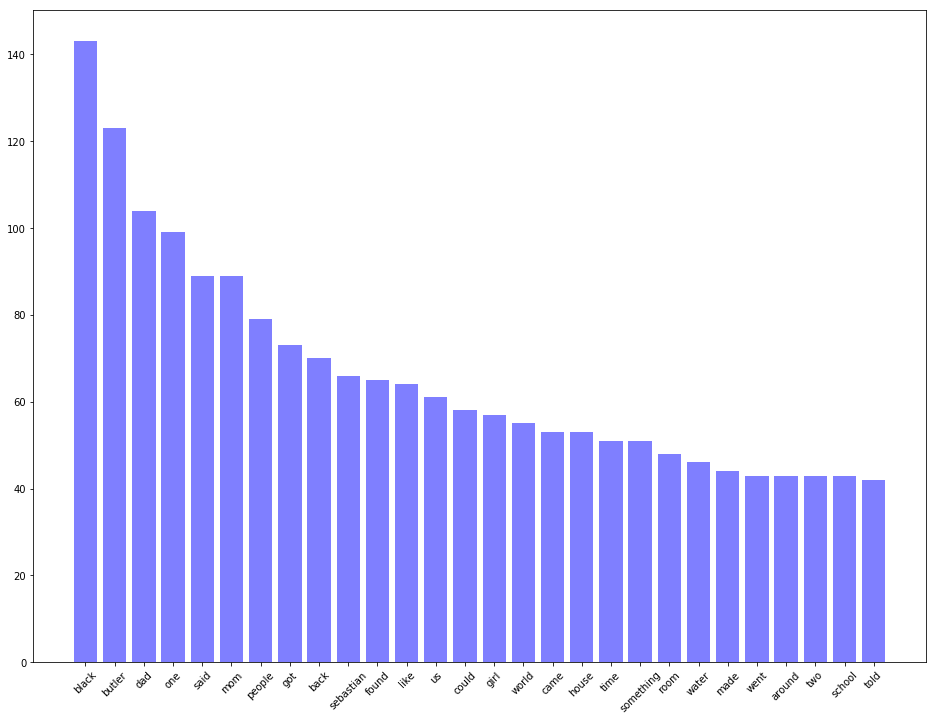

In [72]:
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re

#nltk.download()  #Need to download for the stopwords

Name = "Sebastian"
DreamBankID = 666
W266ID = 666
Sex = "M"
dreams = []

#for n in range(50):
#    dreams.append("I dreamt that I am Sebastian, the demon butler from the anime Black Butler.")
    
#dreams.append("Okay, I am also crazy about the video game Perfect World.")

with open('BassyDreamJournal2.txt') as inputfile:
    for row in csv.reader(inputfile):
        strRow = str(row).lower()
        strRow = re.sub('[\W_]+', ' ', strRow, flags=re.UNICODE) 
        
        dreams.append(str(strRow).lower())

dreamsgraph = " ".join(dreams)        
dreamsgraph = list(nltk.tokenize.word_tokenize(dreamsgraph))
dreamsgraph = [word for word in dreamsgraph if word not in stopwords.words('english')]
dreamsgraph = [word for word in dreamsgraph if word not in ['x94', 'x92t', 'ti', 'x92d', 'x92s', 'x85']]

counts = Counter(dreamsgraph)
for k in list(counts):
    if counts[k] < 40:
        del counts[k]

print counts

labels, values = zip(*counts.items())        

# sort in descending order
indSort = np.argsort(values)[::-1]

labels = np.array(labels)[indSort]
values = np.array(values)[indSort]
indexes = np.arange(len(labels))

plt.bar(indexes, values, align='center', alpha=0.5, color='blue')
plt.xticks(indexes, labels, rotation=45) #+ bar_width

# Get current size
fig_size = plt.rcParams["figure.figsize"]
# print "Current size:", fig_size

# Set figure width to 12 and height to 9
fig_size[0] = 16
fig_size[1] = 12
plt.rcParams["figure.figsize"] = fig_size

plt.show()



In [73]:
TempDream = []

for Dream in dreams:
    ID += 1
    
    TempDream = list(nltk.tokenize.word_tokenize(Dream))
    TempDream = [word for word in TempDream if word not in stopwords.words('english')]
    TempDream = [word for word in TempDream if word not in ['x93i', 'x94', 'x92t', 'ti', 'x92d', 'x92s', 'x85']]
        
    TempDream = " ".join(TempDream)                
    
    # print TempDream
    
    Dream = TempDream

    df = df.append({
        "ID": ID,
        "W266ID": W266ID,
        "DreamBankID": DreamBankID,
        "DreamNumber": 665 + ID,
        "Name": Name,
        "Sex": Sex,
        "Dream": Dream
        }, ignore_index=True)        

    
# randomly shuffle dataframe
# set seed for consistency while running
np.random.seed(0)
df = df.sample(frac=1).reset_index(drop=True)
    
# add 41 flag columns denoting dreamers (one col per dreamer) 
dreamer_flag = pd.get_dummies(df['W266ID'], prefix='Dreamer')
df = pd.concat([df, dreamer_flag], axis=1)

# create vocab from all dreams
dreams_flat = df['Dream'].values.flatten().tolist()
dreams_list = " ".join(dreams_flat)
vocab = list(set(nltk.tokenize.word_tokenize(dreams_list)))

print "Total Dreams: " + str(ID)
print "\n"



Total Dreams: 26859




In [74]:
#print vocab


In [90]:

def split_data(df, W266ID, train=0.80):        
    # column for "our" dreamer
    dreamer_label = 'Dreamer_' + str(W266ID)

    # make 60/40 split of train/test
    # test will be evenly split between dev and test in the next step
    num_train = int(len(df) * train)
    num_test = int(len(df) * (1-train)) 

    train_data, train_labels = df['Dream'][:num_train], df[dreamer_label][:num_train]
    dev_data, dev_labels = df['Dream'][-num_test : -num_test//2], df[dreamer_label][-num_test : -num_test//2] 
    test_data, test_labels = df['Dream'][-num_test//2:], df[dreamer_label][-num_test//2:]

    return train_data, train_labels, dev_data, dev_labels, test_data, test_labels

ToyModel = {}

# split data for dreamer666 - Sebastian
DreamerID = 666

train_data, train_labels, dev_data, dev_labels, test_data, test_labels = split_data(df, W266ID=DreamerID)

print 'Number of dreams: ' + str(sum(train_labels))
print 'Total number in DreamBank (training): ' + str(len(train_labels))
print '\n'

# Create a Bag-of-Words Vectorizer
vec = CountVectorizer(vocabulary=vocab)
print vec

vec_bow_train_data = vec.fit_transform(train_data)
vec_bow_dev_data = vec.transform(dev_data)  

## Logistic reg
bow_log = LogisticRegression(C = 0.01)
bow_log.fit(vec_bow_train_data / np.std(vec_bow_train_data, 0), train_labels)

# find the most-predictive features
### we're not using the weights currently, but might be useful/interesting later ###    
best_feature_positions = bow_log.coef_.argsort()[0][-10::]
best_feature_weights = bow_log.coef_[0][best_feature_positions.astype(int)]

print best_feature_positions
print best_feature_weights

f1_bow_lr_score = metrics.f1_score(dev_labels, bow_log.predict(vec_bow_dev_data), average='macro')

# get word labels for our features
words = []
for ft in best_feature_positions.astype(int):
    words.append(vec.get_feature_names()[ft])

ToyModel[DreamerID] = (bow_log, f1_bow_lr_score, words)

for key, (model, score, predictive_words) in ToyModel.iteritems():
    print model 
    print '\n'
    print 'F1 score: ' + str(score)
    print 'W266ID='+str(key), '\tMost Predictive', predictive_words


Number of dreams: 680
Total number in DreamBank (training): 21487


CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern=u'(?u)\\b\\w\\w+\\b',
        tokenizer=None,
        vocabulary=['fawn', 'Ptomeny', 'grandniece', '1,800', 'wrought-iron', 'Poetry', "'glue", 'woods', 'clotted', 'spiders', 'hanging', 'woody', 'comically', 'localized', 'Prone', 'sevens', 'disobeying', 'caner', 'canes', 'DISAPPOINTED', 'unpaused', 'scold', 'jell-o', 'tingle', 'Western', 'Retreat', 'boc... 'flatfish', 'up-side-down', 'Palides', 'Choquehuanca', 'her/or', 'architect', 'expands', 'jawbone'])


IndexError: tuple index out of range

In [130]:
#==================================================================
# Cell Purpose:  Run Logisitic Regression for each dreamer
#                This creates a logistic Regression for Each Dreamer
#                with a "one" versus "rest" methodology
#==================================================================
import time
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

PROGRESSION_PRINTOUTS_ON = True

cell_start = time.time()

models = {}

for i in range(666,667):
    if PROGRESSION_PRINTOUTS_ON:
        print "Progression: Logistic Regression for dreamer ", i
    # split data
    train_data, train_labels, dev_data, dev_labels, test_data, test_labels = split_data(df, W266ID=i)
    
    # Create a Bag-of-Words Vectorizer
    vec_bow = CountVectorizer(vocabulary=vocab)
    print len(vocab)
    
    vec_bow_train_data = vec_bow.fit_transform(train_data)
    # vec_bow_train_data = preprocessing.scale(vec_bow_train_data)  # how to do this?
    vec_bow_dev_data = vec_bow.transform(dev_data)  
    print vec_bow_train_data.shape
    print type(vec_bow_train_data)
    
    #scaler = StandardScaler(with_mean=False)
    #vec_bow_train_data = scaler.fit(vec_bow_train_data)
    
    # Create a TF Vectorizer
    vec_tf = TfidfTransformer(use_idf=False, smooth_idf=False)
    vec_tf_train_data = vec_tf.fit_transform(vec_bow_train_data)
    vec_tf_dev_data   = vec_tf.transform(vec_bow_dev_data)     

    # Create a TF-IDF Vectorizer
    vec_tfidf = TfidfVectorizer(stop_words='english')
    vec_tfidf_train_data = vec_tfidf.fit_transform(train_data)
    vec_tfidf_dev_data   = vec_tfidf.transform(dev_data)    

    ## Logistic reg
    bow_log = LogisticRegression(C = 100)
    #print vec_bow_train_data
    
    # std_bow_train_data = vec_bow_train_data / np.std(vec_bow_train_data, 0) 'Tuple out of range
    bow_log.fit(vec_bow_train_data, train_labels)

    tf_log = LogisticRegression(C = 100)
    tf_log.fit(vec_tf_train_data, train_labels)
    
    tfidf_log = LogisticRegression(C = 100)
    tfidf_log.fit(vec_tfidf_train_data, train_labels)    
    
    # score models
    f1_bow = metrics.f1_score(dev_labels, bow_log.predict(vec_bow_dev_data), average='macro')
    f1_tf = metrics.f1_score(dev_labels, tf_log.predict(vec_tf_dev_data), average='macro')    
    f1_tfidf = metrics.f1_score(dev_labels, tfidf_log.predict(vec_tfidf_dev_data), average='macro')

    
    # find the most-predictive features
    ### we're not using the weights currently, but might be useful/interesting later ###    
    best_feature_positions_bow = bow_log.coef_.argsort()[0][-10::]
    best_feature_weights_bow = bow_log.coef_[0][best_feature_positions_bow.astype(int)]
    
    best_feature_positions_tf = tf_log.coef_.argsort()[0][-10::]
    best_feature_weights_tf = tf_log.coef_[0][best_feature_positions_tf.astype(int)]  
    
    best_feature_positions_tfidf = tfidf_log.coef_.argsort()[0][-10::]
    best_feature_weights_tfidf = tfidf_log.coef_[0][best_feature_positions_tfidf.astype(int)]    

    # get word labels for our features
    bow_best_words = []
    for ft in best_feature_positions_bow.astype(int):
        bow_best_words.append(vec_bow.get_feature_names()[ft])
        
    tf_best_words = []
    for ft in best_feature_positions_tf.astype(int):
        tf_best_words.append(vec_bow.get_feature_names()[ft])
        
    tfidf_best_words = []
    for ft in best_feature_positions_tfidf.astype(int):
        tfidf_best_words.append(vec_tfidf.get_feature_names()[ft])
    
    # reverse-sort lists so they are in proper order
    bow_best_words.reverse()
    tf_best_words.reverse()
    tfidf_best_words.reverse()    
    
    models[i] = (bow_log, tf_log, tfidf_log, bow_best_words, tf_best_words, tfidf_best_words)
    
print 'Cell Runtime:', round(time.time() - cell_start), 'seconds'

Progression: Logistic Regression for dreamer  666
58623
(21487, 58623)
<class 'scipy.sparse.csr.csr_matrix'>
Cell Runtime: 9.0 seconds


In [131]:
#==================================================================
# Cell purpse: Show the most predictive words from models per dreamer
#              BOW
#              TF (term frequence)
#              TFIDF
#==================================================================

for key, (bow_mod, tf_mod, tfidf_mod, bow_best_words, tf_best_words, tfidf_best_words) in models.iteritems():
    print 'W266ID='+str(key)
    print 'Most Predictive BOW', bow_best_words
    print 'Most Predictive TF', tf_best_words    
    print 'Most Predictive TF-IDF', tfidf_best_words, '\n'

W266ID=666
Most Predictive BOW ['everybody', 'jaylah', 'black', 'mom', 'piano', 'dad', 'art', 'dance', 'could', 'staring']
Most Predictive TF ['everybody', 'black', 'dad', 'mom', 'jaylah', 'girl', 'could', 'butler', 'grammy', 'staring']
Most Predictive TF-IDF [u'butler', u'jaylah', u'grammy', u'staring', u'micheo', u'everybody', u'dad', u'parents', u'deciding', u'robo'] 



In [78]:
#==================================================================
# Cell Purpose: Set up the df to do Topic Modeling 
#               Split the dream documents into tokens
#==================================================================

dreams = list(df['Dream'])

# Split the documents into tokens.
for idx in range(len(dreams)):
    dreams[idx] = dreams[idx].lower()  # Convert to lowercase.
    dreams[idx] = nltk.tokenize.word_tokenize(dreams[idx])  # Split into words.
    dreams[idx] = nltk.pos_tag(dreams[idx])  # tag with PoS
    dreams[idx] = [token for token, tag in dreams[idx] if tag.startswith('N')]   # only keep nouns 
    
# Remove numbers, but not words that contain numbers.
dreams = [[token for token in dream if not token.isdigit()] for dream in dreams]

# Remove words that are only one or two characters.
dreams = [[token for token in dream if len(token) > 2] for dream in dreams]

# Lemmatize the dreams.
lmtzr = WordNetLemmatizer()
dreams = [[lmtzr.lemmatize(token) for token in dream] for dream in dreams]

In [79]:
# Remove rare and common tokens.
# Create a dictionary representation of the dreams.
dictionary = Dictionary(dreams)

# Filter out words that occur less than 5 dreams, or more than 60% of the dreams.
dictionary.filter_extremes(no_below=5, no_above=0.6)

# Vectorize data.

# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(dream) for dream in dreams]

print('Number of unique tokens: %d' % len(dictionary))
print('Number of dreams: %d' % len(corpus))

Number of unique tokens: 8025
Number of dreams: 26859


In [80]:
# Train LDA model.

# Set training parameters.
num_topics = 50
chunksize = 20000
passes = 30
iterations = 400
eval_every = None  # Don't evaluate model perplexity, takes too much time.

# Make a index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

%time model = LdaModel(corpus=corpus, id2word=id2word, chunksize=chunksize, \
                       alpha='auto', eta='auto', iterations=iterations, num_topics=num_topics, \
                       passes=passes, eval_every=eval_every)

Wall time: 24min 29s


In [81]:
top_topics = model.top_topics(corpus, topn=10)

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics
print('Average topic coherence: %.4f.' % avg_topic_coherence)

from pprint import pprint
pprint(top_topics)

Average topic coherence: -3.2884.
[([(0.081193713009566806, u'/td'),
   (0.076299563195520864, u'question'),
   (0.065797518368660504, u'answer'),
   (0.048316795999480994, u'top'),
   (0.047715057179341165, u'table'),
   (0.046807409069452514, u'interpretation'),
   (0.042630346650579277, u'cellpadding='),
   (0.042630346562144796, u'cellspacing='),
   (0.042630346550083083, u'border='),
   (0.042630346529837201, u'valign=')],
  -0.4496401556876049),
 ([(0.098768273053005423, u'/li'),
   (0.087843874831823821, u'feeling'),
   (0.068235128596770431, u'character'),
   (0.066262788129135941, u'thought'),
   (0.060894074846381624, u'setting'),
   (0.0419289547951225, u'friend'),
   (0.035680204931752543, u'/ul'),
   (0.031443061109124738, u'dream'),
   (0.019848146942933347, u'school'),
   (0.017836319716013238, u'mom')],
  -1.1783086339887989),
 ([(0.12795201629778055, u'guy'),
   (0.037657976636868651, u'people'),
   (0.036978979804724359, u'mom'),
   (0.033517459848246701, u'something'

 ([(0.11397408256234777, u'bill'),
   (0.046628939126542569, u'letter'),
   (0.030357247490719563, u'grandma'),
   (0.021567854616785991, u'jane'),
   (0.017555431287358217, u'mail'),
   (0.01638135093069111, u'something'),
   (0.015043640219355036, u'grandpa'),
   (0.013062038434679804, u'butler'),
   (0.012237208946547876, u'relationship'),
   (0.011412843205990578, u'someone')],
  -6.1882190680166076),
 ([(0.058598351556828208, u'tree'),
   (0.034924413197091018, u'snake'),
   (0.032546920975558259, u'ann'),
   (0.027360416227497981, u'bob'),
   (0.024467924484172471, u'guard'),
   (0.023078753708982488, u'barn'),
   (0.016669671353834365, u'pig'),
   (0.016205954639605315, u'head'),
   (0.014895910449412434, u'prisoner'),
   (0.011983396318817244, u'judy')],
  -6.3621887539401492),
 ([(0.11205766184434905, u'doctor'),
   (0.043895087226125507, u'bottle'),
   (0.035271202921130021, u'shower'),
   (0.025627191288982332, u'milk'),
   (0.016584958109564122, u'result'),
   (0.0149818849

In [82]:
# show top topics for dreamerID #666
for key, (mod, corp, dic) in topic_models.iteritems():
    if key == 666:
        print "\nDreamer", key
        pprint(mod.top_topics(corpus = corp))


Dreamer 666
[([(0.55731887253135459, u'butler'),
   (0.28067511894251368, u'demon'),
   (0.032664463848481137, u'anime'),
   (0.032338535819832592, u'okay'),
   (0.032338213524431336, u'video'),
   (0.032334322382916551, u'world'),
   (0.032330472950470139, u'game')],
  -17.868381313196068),
 ([(0.55768824077722878, u'butler'),
   (0.28071390781555161, u'demon'),
   (0.03256347599025456, u'anime'),
   (0.032261512740158864, u'okay'),
   (0.032261214058138643, u'video'),
   (0.032257608007180548, u'world'),
   (0.032254040611487067, u'game')],
  -17.868381313196068)]


In [84]:
test_flat = list(df[df['W266ID'] == 666]['Dream'])
test_token = [nltk.tokenize.word_tokenize(dream) for dream in test_flat]
test_final = [item for items in test_token for item in items]
test_counts = Counter(test_final)
test_counts

Counter({'roble': 7,
         'yellow': 1,
         'four': 12,
         'circuitry': 1,
         'sleep': 15,
         'spiders': 5,
         'hanging': 11,
         'mansion': 3,
         'oldest': 1,
         'saved': 3,
         'worked': 2,
         'marching': 2,
         'looking': 20,
         'dalek': 1,
         'replacements': 1,
         'chinese': 11,
         'electricity': 3,
         'blacking': 1,
         'x93otokonoko': 1,
         'neighbours': 3,
         'hallucinate': 1,
         'teaching': 1,
         'regan': 1,
         'onstage': 3,
         'playground': 3,
         'sinking': 1,
         'x93then': 1,
         'rescue': 1,
         'blanket': 2,
         'mata': 1,
         'every': 19,
         'lecture': 2,
         'jacob': 2,
         'stabbed': 1,
         'fireplace': 1,
         'excited': 2,
         'look': 13,
         'doumo': 1,
         'school': 43,
         'basics': 1,
         'prize': 1,
         'x93like': 1,
         'called': 9,
      

In [85]:
#==================================================================
# Cell Purpose:  Use all 26000 documents to create Corpus
#                Train a LDA model on full corpus
#==================================================================
dreams = list(df['Dream'])

# Split the documents into tokens.
for idx in range(len(dreams)):
    dreams[idx] = dreams[idx].lower()  # Convert to lowercase.
    dreams[idx] = nltk.tokenize.word_tokenize(dreams[idx])  # Split into words.
    
print "Progress Update: Finished splitting documents"
# Remove numbers, but not words that contain numbers.
dreams = [[token for token in dream if not token.isdigit()] for dream in dreams]

print "Progress Update: removed numbers"
# Remove words that are only one or two characters.
dreams = [[token for token in dream if len(token) > 2] for dream in dreams]

# Remove other words that are artifacts of data
# remove /d, cellpadding, =, etc.

print "Progress Update: Removed short words "
# Lemmatize the dreams.
lmtzr = WordNetLemmatizer()
dreams = [[lmtzr.lemmatize(token) for token in dream] for dream in dreams]

Progress Update: Finished splitting documents
Progress Update: removed numbers
Progress Update: Removed short words 


In [86]:
DEBUG_VERBOSITY_HIGH = False
if DEBUG_VERBOSITY_HIGH:
    print len(dreams)
    for i in range(0,100):
        print len(dreams[i])

In [87]:
#==================================================================
# Cell Purpose: Create a dictionary representation of the dreams
#               Corpus is a Bag-of-words representation
#==================================================================

## Remove rare and common tokens.
dictionary = Dictionary(dreams)

# Filter out words that occur less than 5 dreams, 
# Experimented with removing more than 60% of the dreams.
# But this was shown to have no effect (screen out more than 60% of dreams)
dictionary.filter_extremes(no_below=5)

#----------------
# Vectorize data.
#----------------
# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(dream) for dream in dreams]

print('Number of unique tokens: %d' % len(dictionary))
print('Number of dreams: %d' % len(corpus))

Number of unique tokens: 13944
Number of dreams: 26859


In [88]:
#==================================================================
# Cell Purpse:  Create a dictionary representation of the dreams.
#==============================================================
# Make a index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

In [133]:
#==================================================================
# Cell Purpse: Load  previously trained LDA model 
#              or else train LDA Model
#================================================================== 
CREATE_FULL_CORPUS_LDA_MODEL = True
MAX_TOPICS = True
LDA_MODEL_200_TOPIC_PATH_FILE = './model/topics200/DreamLda200.model'
LDA_MODEL_200_TOPIC_PATH_FILE = './model/topics100/DreamLda100.model'
LDA_MODEL_50_TOPIC_PATH_FILE  = './model/topics50/DreamLda.model'

if CREATE_FULL_CORPUS_LDA_MODEL:
    # Set training parameters.
    num_topics = 200
    chunksize = 26000/10
    passes = 10
    iterations = 400
    eval_every = None  # Don't evaluate model perplexity, takes too much time.

    %time dreamerLdaModel = LdaModel(corpus=corpus, id2word=id2word, chunksize=chunksize, \
                           alpha='auto', eta='auto', iterations=iterations, num_topics=num_topics, \
                           passes=passes, eval_every=eval_every)
    if MAX_TOPICS:
        dreamerLdaModel.save(LDA_MODEL_200_TOPIC_PATH_FILE)
    else: 
        dreamerLdaModel.save(LDA_MODEL_50_TOPIC_PATH_FILE)
else: 
    if MAX_TOPICS:
        # Model with 200 Topics
        dreamerLdaModel = LdaModel.load(LDA_MODEL_200_TOPIC_PATH_FILE)
    else:
        # Model with 50 Topics
        dreamerLdaModel = LdaModel.load(LDA_MODEL_50_TOPIC_PATH_FILE)

Wall time: 49min 7s


IOError: [Errno 2] No such file or directory: './model/topics100/DreamLda100.model.state'

In [ ]:
top_topics = dreamerLdaModel.top_topics(corpus, topn=50)

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics
print('Average topic coherence: %.4f.' % avg_topic_coherence)

from pprint import pprint
pprint(top_topics)

In [ ]:
#==================================================================
# Cell Purpse: 1)Take a dreamer from the Collection
#              2) Create a BOW for each dream
#              3) Create the LDA_Vector 
#              4) Compute the top topics per dreaml
#================================================================== 

# Take Dreamer i and transform the dreams into a bow
# cell_start = time.time()
DEBUG_VERBOSITY_HIGH = False


text = "The one at the Meads's house, where it's bigger inside than out; there's a European village just inside, with a cobblestone street and a Pied-Piper sort of man with curly hair, he can do things like juggle - I go up the back stairs [there aren't any in the real house] and then down the other side [since there's a second set, immediately] then down a short empty hallway that turns a corner, where I find a tiny room...a young woman with shoulder-length blonde hair in a pageboy is there, cooking at a stove that almost fills the room...she's nice to me. Now outside, I'm waiting for my aunt to pick me up - she arrives in a little round convertible and we go for a drive, not very far - we cross a little bridge over a creek, then double back and she drops me off at the house again. Inside (?) I sit with a couple of people, playing with a string of blue balloons."
#bow_vector = dictionary.doc2bow(dream)
bow_vector = dictionary.doc2bow(nltk.tokenize.word_tokenize(text))
bow_vector2 = dictionary.doc2bow(dreams[1])
lda_vector = dreamerLdaModel[bow_vector2]
print(lda_vector)
print(dreamerLdaModel.print_topic(max(lda_vector, key=lambda item: item[1])[0]))


if DEBUG_VERBOSITY_HIGH:
    print len(bow_vector2)
    #print bow_vector2
    print([(dictionary[id], count) for id, count in bow_vector2])
    print "\n"
    print len(bow_vector)
    print([(dictionary[id], count) for id, count in bow_vector])

In [ ]:
lda_vector = model[bow_vector]
print(lda_vector)
print(model.print_topic(max(lda_vector, key=lambda item: item[1])[0]))